<a id='top'></a>

# CSCI 3022: Intro to Data Science - Fall 2020 Practicum 2

***

**Name**: Matt Ceriello

***

**Partner Name** (if applicable):

***

*Each individual must submit a copy of this activity - even if you worked with a partner. If you worked with a partner, you and your partner should have similar / identical work on the problems below, but your name (as the submitting student) and your partner's name should be accurately represented in the fields above.*

This practicum is due on Canvas by **10:00 PM on Saturday, December 12** (the end of your Finals Period). Your solutions to theoretical questions should be done in Markdown/MathJax directly below the associated question.  Your solutions to computational questions should include any specified Python code and results as well as written commentary on your conclusions. 

**Here are the rules:** 

1. All work, code and analysis, must be your own - either alone or with your partner. 
2. You may use your course notes, posted lecture slides, textbooks, in-class notebooks, and homework solutions as resources.  You may also search online for answers to general knowledge questions like the form of a probability distribution function or how to perform a particular operation in Python/Pandas. 
3. This is meant to be like a coding portion of your midterm exam. So, the instructional team will be much less helpful than we typically are with homework. For example, we will not check answers, help debug your code, and so on. (There is a limited exception in Problem 2B)
4. If something is left open-ended, it is because we want to see how you approach the kinds of problems you will encounter in the wild, where it will not always be clear what sort of tests/methods should be applied. Feel free to ask clarifying questions in office hours or on a private Piazza post.
5. You may **NOT** post to public message boards or other online resources asking for help.
6. You may **NOT** copy-paste solutions *from anywhere*.
7. You may **NOT** collaborate with classmates or anyone else (other than your partner).
8. In short, **your work must be your own**. It really is that simple.

Violation of the above rules will result in an immediate academic sanction (*at the very least*, you will receive a 0 on this practicum or an F in the course, depending on severity), and a trip to the Honor Code Council.

**By submitting this assignment, you agree to abide by the rules given above.**

**NOTES**: 

- You may not use late days on the practicums nor can you drop your practicum grades. 
- If you have a question for us, post it as a **PRIVATE** message on Piazza.  If we decide that the question is appropriate for the entire class, then we will add it to a Practicum clarifications thread. 
- Do **NOT** load or use any Python packages that are not available in Anaconda 3.6. 
- Some problems with code may be autograded.  If we provide a function API **do not** change it.  If we do not provide a function API then you're free to structure your code however you like. 
- Submit only this Jupyter notebook to Canvas.  Do not compress it using tar, rar, zip, etc. 
- This should go without saying, but... For any question that asks you to calculate something, you **must show all work to receive credit**. Sparse or nonexistent work will receive sparse or nonexistent credit.


---

In [1]:
from scipy import stats
from math import isnan
import numpy as np 
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from calendar import month_name, different_locale

# Problem 1: Urbanization (50 pts)
It is January of 1963, and President Kennedy has hired you as the Chief Statistician for the White House!  Your first task is to analyze and report state expenditures across the country$^1$.  You feel ready for the challenge, since you studied so hard in your statistical methods class.  On day one, JFK hands you an important data set that contains information on the 48 states in the contiguous U.S. describing per capita state and local public expenditures associated with state demographic and economic characteristics in 1960$^2$ . The data set is found in the file `stateExpenditures.txt`.

You are told that you need to quantify **how per capita state and local expenditures can be explained and predicted** by:
* The economic ability index
* The percentage of the population living in a metropolitan area
* The percentage change in the population between 1950 and 1960
* The percentage of the population aged 5-19 years
* The percentage of the population over 65 years old
* Whether the state is located in the western part of the United States or not

The variables available in the data set are labeled as follows:

* EX: 		Per capita state and local public expenditures (USD)
* ECAB: 	Economic ability index, in which income, retail sales, and the value of output (manufactures, mineral, and agricultural) per capita are equally weighted
* MET: 		Percentage of population living in standard metropolitan areas
* GROW: 	Percent change in population, 1950-1960
* YOUNG: 	Percent of population aged 5-19 years
* OLD: 		Percent of population over 65 years of age
* WEST: 	Western state (1) or not (0)

Keep in mind that the president does not know how to interpret linear model output, and he wants answers in terms of things that are easily read and understood.  Therefore, when analyzing your models, *be sure your answers are friendly for a general audience, but include enough technical information that your statistics professor believes you know what you're talking about*.

$^1$ Just pretend that today's hardware and software existed in 1963 - no need to purchase a variety of vacuum tubes!

$^2$ U.S. Department of Commerce, Bureau of the Census, Government Finances in 1960, Census of Population (1960),  Census of Manufactures (1958), Statistical Abstract of the United States (1961), U.S. Department of Agriculture, Agricultural Statistics (1961), and the U.S. Department of the Interior, Minerals Yearbook (1960).

### 1A) Load Your Dataset
Load in the data set saved in "stateExpenditures.txt".  Save it into a data frame.

In [2]:
#YOUR CODE FOR 1A HERE
filepath = "stateExpenditures.txt"
nmes = ["EX","ECAB","MET","GROW","YOUNG","OLD","WEST","STATE"]
df = pd.read_table(filepath, sep="\t", names = nmes)
df = df.iloc[1:]
df["EX"] = df["EX"].astype(int)
df["ECAB"] = df["ECAB"].astype(float)
df["MET"] = df["MET"].astype(float)
df["GROW"] = df["GROW"].astype(float)
df["WEST"] = df["WEST"].astype(int)
df["STATE"] = df["STATE"].astype(str)
df.head()


,EX,ECAB,MET,GROW,YOUNG,OLD,WEST,STATE
1,256,85.5,19.7,6.9,29.6,11.0,0,ME
2,275,94.3,17.7,14.7,26.4,11.2,0,NH
3,327,87.0,0.0,3.7,28.5,11.2,0,VT
4,297,107.5,85.2,10.2,25.1,11.1,0,MA
5,256,94.9,86.2,1.0,25.3,10.4,0,RI


### 1B) Consider Variable Nonlinearity
The effects of the metrolpolitan variables are highly nonlinear!  One way to approach this is to consider it as a categorical variables instead.  Convert MET to a categorical variable $METcateg$ that denotes which level MET each state is in by dividing MET up into units of 15:

Set METcateg equal to
  \begin{array}{l l}
    METcateg=1 & \quad \text{if $MET < 15$}\\
    METcateg=2 & \quad \text{if $15 \le MET < 30$}\\
    METcateg=3 & \quad \text{if $30 \le MET < 45$}\\
    METcateg=4 & \quad \text{if $45 \le MET < 60$}\\
    METcateg=5 & \quad \text{if $60 \le MET < 75$}\\
    METcateg=6 & \quad \text{if $75 \le MET$}\\    
  \end{array} 

In [3]:
#dfnew = df
df["METcateg"] = df["MET"]

for index in df.index:
    if df.loc[index,"MET"] < 15:
        df.loc[index,"METcateg"] = 1
    
    elif df.loc[index,"MET"] >= 15 and df.loc[index,"MET"] < 30:
        df.loc[index,"METcateg"] = 2
    
    elif df.loc[index,"MET"] >= 30 and df.loc[index,"MET"] < 45:
        df.loc[index,"METcateg"] = 3
    
    elif df.loc[index,"MET"] >= 45 and df.loc[index,"MET"] < 60:
        df.loc[index,"METcateg"] = 4
    
    elif df.loc[index,"MET"] >= 60 and df.loc[index,"MET"] < 75:
        df.loc[index,"METcateg"] = 5
        
    elif df.loc[index,"MET"] >= 75:
        df.loc[index,"METcateg"] = 6

df["METcateg"] = df["METcateg"].astype(int)
df.head()

,EX,ECAB,MET,GROW,YOUNG,OLD,WEST,STATE,METcateg
1,256,85.5,19.7,6.9,29.6,11.0,0,ME,2
2,275,94.3,17.7,14.7,26.4,11.2,0,NH,2
3,327,87.0,0.0,3.7,28.5,11.2,0,VT,1
4,297,107.5,85.2,10.2,25.1,11.1,0,MA,6
5,256,94.9,86.2,1.0,25.3,10.4,0,RI,6


### 1C) Visualize Your Covariates
Make pairwise scatter plots of the continuous covariates, both against each other and against the outcome (expenditures).   Does the relationship between the independent variables and the dependent variables appear to be linear?  Do there appear to be independent variables that are collinear?  You may import the package `seaborn` if desired.

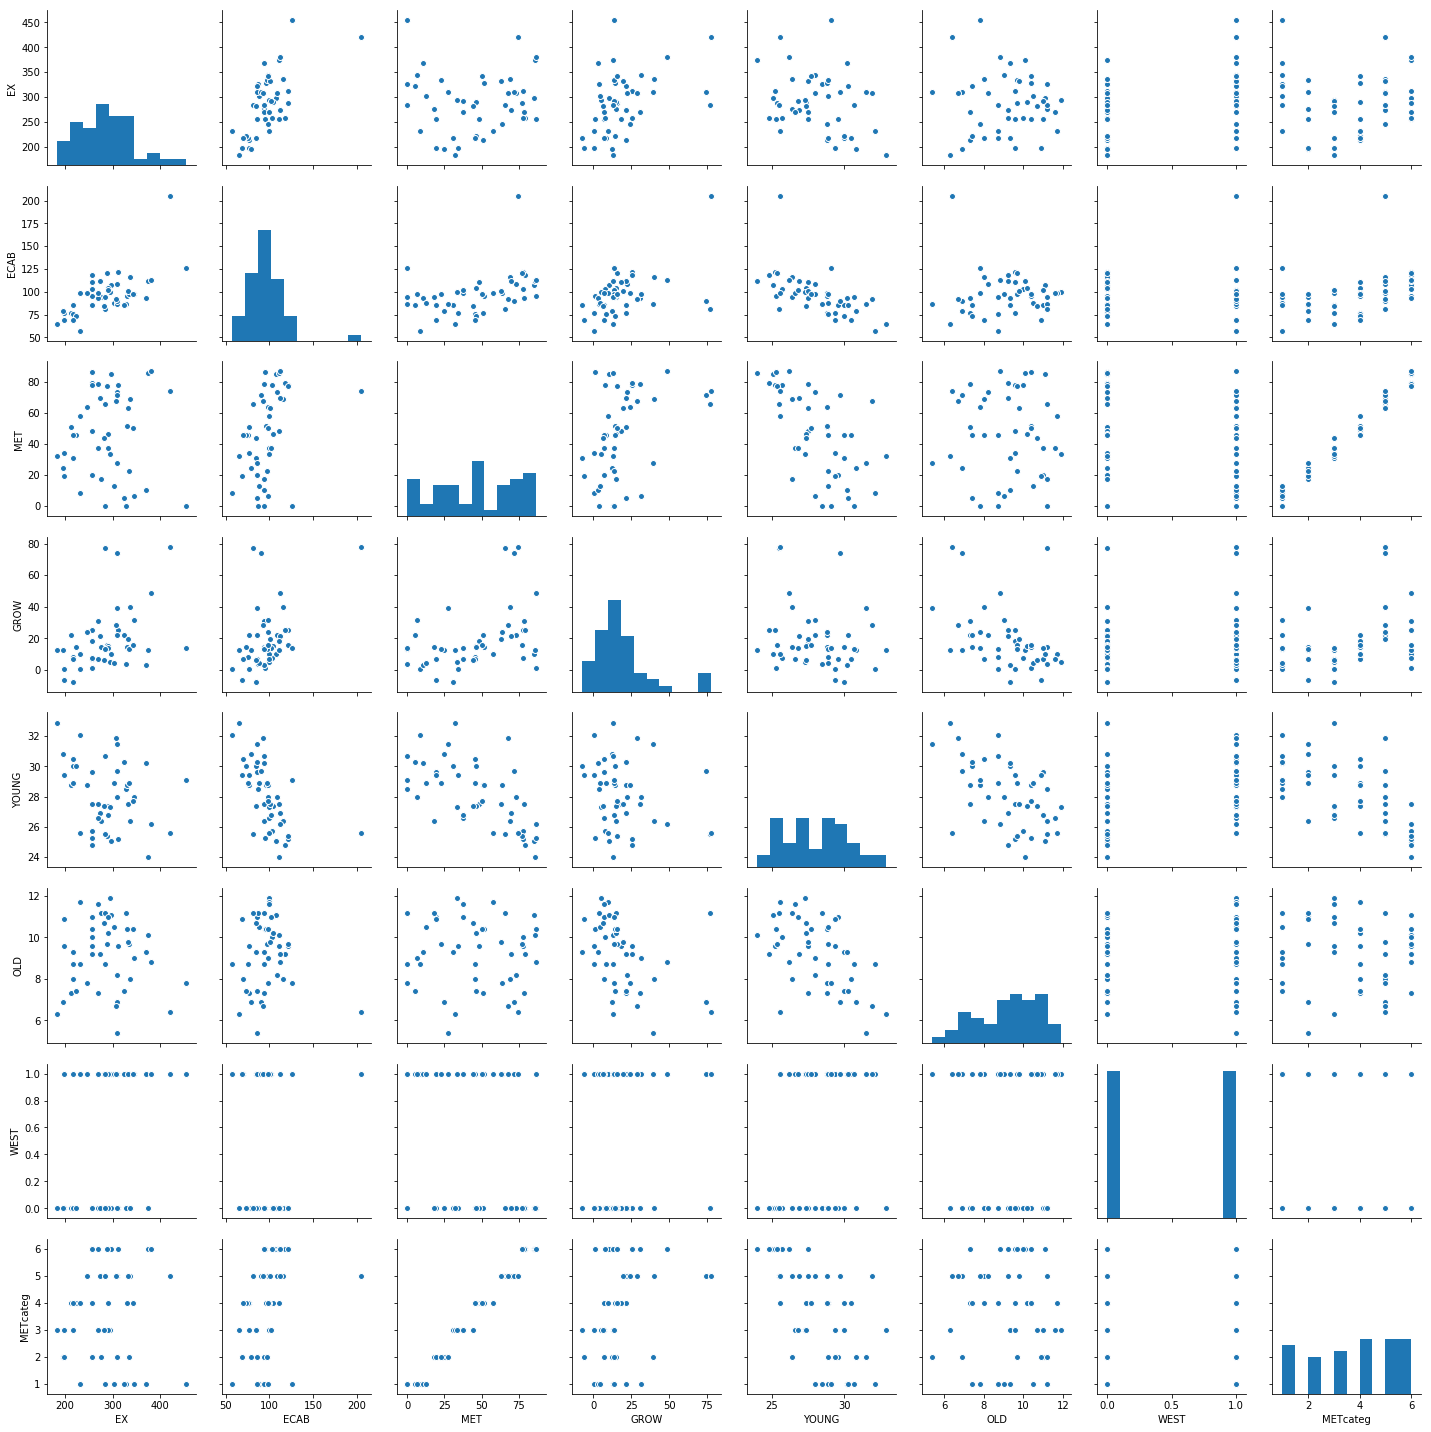

In [4]:
#YOUR CODE FOR 1C HERE
sns.pairplot(df)

### 1D) Run Your Full Model
Fit the full model using `stats.OLS` in Python.  Then in a markdown cell, write out the estimated full model, adjusted $R^2$ value, and interpret the parameters in sentences with appropriate units.

In [5]:
#YOUR CODE FOR 1D HERE

y, X = df["EX"], df.iloc[:,1:7]
X = sm.add_constant(X)
model = sm.OLS(y, X.astype(float)).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     EX   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     10.22
Date:                Sat, 12 Dec 2020   Prob (F-statistic):           6.63e-07
Time:                        21:09:32   Log-Likelihood:                -241.20
No. Observations:                  48   AIC:                             496.4
Df Residuals:                      41   BIC:                             509.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        356.1818    306.486      1.162      0.252    -262.780     975.143
ECAB           1.4185      0.430      3.298      0.002       0.550       2.287
MET           -0.6602      0.353     -1.872      0.068      -1.372       0.052
GROW           0.5716      0.425      1.345      0.186      -0.287       1.430
YOUNG         -6.6747      7.481     -0.892      0.377     -21.782       8.433
OLD           -1.8551      7.137     -0.260      0.796     -16.268      12.558
WEST          35.4723     13.771      2.576      0.014       7.661      63.284
==============================================================================
Omnibus:                        0.723   Durbin-Watson:                   2.349
Prob(Omnibus):                  0.697   Jarque-Bera (JB):                0.524
Skew:                           0.253   Prob(JB):                        0.770
Kurtosis:                       2.927   Cond. No.                     6.18e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.18e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [6]:
print(model.params)

const    356.181848
ECAB       1.418502
MET       -0.660153
GROW       0.571590
YOUNG     -6.674659
OLD       -1.855073
WEST      35.472336
dtype: float64


**Full Model**

$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \beta_4 x_4 + \beta_5 x_5 + \beta_6 x_6$, where $\beta_n$ represents the parameters listed above 

Adjusted $R^2$: .541

<YOUR MARKDOWN FOR 1D HERE>


### 1E) Run a Modified Full Model
Fit a "full" model that includes ECAB, METcateg, GROW, YOUNG, OLD, and WEST.  Write out the estimated model in a markdown cell afterwards.

In [7]:
#YOUR CODE FOR 1E HERE
y, X = df["EX"], df.iloc[:,[1,3,4,5,6,8]]
X = sm.add_constant(X)
model = sm.OLS(y, X.astype(float)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     EX   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     10.28
Date:                Sat, 12 Dec 2020   Prob (F-statistic):           6.24e-07
Time:                        21:09:32   Log-Likelihood:                -241.13
No. Observations:                  48   AIC:                             496.3
Df Residuals:                      41   BIC:                             509.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        354.9784    303.417      1.170      0.249    -257.785     967.741
ECAB           1.4235      0.428      3.326      0.002       0.559       2.288
GROW           0.5515      0.424      1.302      0.200      -0.304       1.407
YOUNG         -6.3963      7.323     -0.873      0.388     -21.186       8.393
OLD           -1.6960      7.057     -0.240      0.811     -15.948      12.556
WEST          33.2001     13.860      2.395      0.021       5.209      61.192
METcateg     -10.2371      5.361     -1.910      0.063     -21.063       0.589
==============================================================================
Omnibus:                        0.767   Durbin-Watson:                   2.321
Prob(Omnibus):                  0.682   Jarque-Bera (JB):                0.436
Skew:                           0.233   Prob(JB):                        0.804
Kurtosis:                       3.034   Cond. No.                     5.57e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.57e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [8]:
print(model.params)

const       354.978376
ECAB          1.423468
GROW          0.551514
YOUNG        -6.396273
OLD          -1.695957
WEST         33.200090
METcateg    -10.237054
dtype: float64


**Full Model**

$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \beta_4 x_4 + \beta_5 x_5 + \beta_6 x_6$, where $\beta_n$ represents the parameters listed above 

Adjusted $R^2$: .542

<YOUR MARKDOWN FOR 1E HERE>


### 1F) Reduce Your Model
Perform *backwards selection* on this model.  Starting with the full model created in part 1D): remove the predictor with the highest p-value, and re-calculate the model without that predictor.  Continue this process until there are no predictors left with p-values greater than 0.05.  Write out your final estimated model. 

In [9]:
#YOUR CODE FOR 1F HERE
y, X = df["EX"], df.iloc[:,1:7]
X = sm.add_constant(X)
model = sm.OLS(y, X.astype(float)).fit()
model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     EX   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     10.22
Date:                Sat, 12 Dec 2020   Prob (F-statistic):           6.63e-07
Time:                        21:09:32   Log-Likelihood:                -241.20
No. Observations:                  48   AIC:                             496.4
Df Residuals:                      41   BIC:                             509.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        356.1818    306.486      1.162      0.252    -262.780     975.143
ECAB           1.4185      0.430      3.298      0.002       0.550       2.287
MET           -0.6602      0.353     -1.872      0.068      -1.372       0.052
GROW           0.5716      0.425      1.345      0.186      -0.287       1.430
YOUNG         -6.6747      7.481     -0.892      0.377     -21.782       8.433
OLD           -1.8551      7.137     -0.260      0.796     -16.268      12.558
WEST          35.4723     13.771      2.576      0.014       7.661      63.284
==============================================================================
Omnibus:                        0.723   Durbin-Watson:                   2.349
Prob(Omnibus):                  0.697   Jarque-Bera (JB):                0.524
Skew:                           0.253   Prob(JB):                        0.770
Kurtosis:                       2.927   Cond. No.                     6.18e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.18e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Here, we can see that the only 2 features with a p-val < .05 are ECAB and WEST.**

###  1G) Compare Your Models
Perform a hypothesis test to determine if the predictors removed from the full model from part 1D) to create the model in 1F) should be kept in the model.  Provide the hypothesis, perform the test, and state the conclusions using p-values.  Be sure to provide your answer in terms of the original problem, and interpret the parameters.

In [10]:
#YOUR CODE FOR 1G HERE

### 1H) Explore A Different Model
Your model in 1F should still include at least some of the levels of MET.  Suppose we removed these, and instead only included the *other* terms. 

- First, make a plot of the residuals of this no-MET model (y) against the *continuous* values of MET (x) from the original problem.
- Before running any code, describe what kinds of *continuous* nonlinear functions or transformations might have captured this type of response.
- Then, implement a polynomial regression capturing the effect of MET while including the same non-MET terms as you did in 2f.
- Plot the residuals of the polynomial regression multiple linear model against the continuous predictor MET, and argue why you've included enough polynomial terms to satisfy any relevant modeling assumptions.

In [11]:
#YOUR CODE FOR 1H HERE


### 1I) Favorite Model
Between all the models above (full model, backwards selection, continuous MET) pick your favorite, and interpret all the parameters.  Why is this model your favorite?  Be sure to provide interpretations in terms of the original problem, including the original scale of the dependent and independent variables.

<YOUR MARKDOWN FOR 1I HERE>

## Problem 2: Amazon Forest Fires
Now that you have shown yourself to be an expert in understanding and managing forest fire risk, a non-profit trying to protect the amazon rain forest has recruited you to join their data science corps. For your first task, they've given you a dataset (`amazon.csv`) with the number of reported forest fires in each state in the Amazon region of Brazil during each month between 1998 and 2017. The Brazilian government has 500 extra wildland firefighters and they have asked your non-profit to determine which state or states they should allocate these firefighters to during each month of the year. To do this, they want you to calculate an 80% confidence interval for the mean and median number of fires that occur during each month for each state, and use those statistics to determine where the firefighters should be assigned.

### A) Loading The CSV
Read the csv located in `amazon.csv` into a pandas data frame. Brazil and many other countries use the period (.) symbol as a thousands separator and a comma (,) as the decimal separator. Ex. One Thousand And $\frac{75}{100}$ would be represented as $1.000,75$ instead of the familiar english notation $1,000.75$. When you read it in, you'll need to use a period(.) as the thousands separator and a comma(,) as the decimal separator. Because the comma is already in use as the decimal separator, this file uses a different character to separate columns in the data. Open up the file in a text editor and figure out what character was used. Then find the correct arguments to `pd.read_csv` to read in this file properly. Look up the docs if you're unsure what the arguments you'll need are. Print out the `.info` summary of the dataframe after you've read it in.

In [12]:
#2A CODE HERE
amazon_fires = pd.read_csv("amazon.csv",sep = ";")
amazon_fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6454 entries, 0 to 6453
Data columns (total 5 columns):
year      6453 non-null object
state     6452 non-null object
month     6454 non-null object
number    6448 non-null object
date      6450 non-null object
dtypes: object(5)
memory usage: 252.2+ KB


### Part B: Data Cleaning

This dataset isn't paticularly useful in it's current state, so we'll need to clean it up a bit. Some data scientists say that most of their job is to wrangle data, so this will give you a taste of cleaning a real world data set. Perform the following tasks. 
1. Drop the 'date' column. The only information this column holds is the year, which we already have in another column. Use the `.info` summary provided to check your work.
2. Drop any rows with null values in any of the remaining columns. Use the provided code to print the number of rows remaining after this step.
3. Print all the unique values of the 'month' column. You'll notice that one is encoded with a differant character encoding then the format that pandas is using.
4. Convert the Portugese month names to English month names. If you'd like to use them, we've included the 'month_name' and the 'different_encoding' modules of the python calendar library. There are many ways to accomplish this task, and these modules are not required, but may make things easier. As part of this step, you should make sure that the Portugese month with the encoding problem is translated to the correct english month. Use the `.unique` method provided for you to check your work. 
5. Check the number column for any values that seem impossible. If you find any values you think are impossible, drop them. As a guidline, we would never expect a single state to have more than 50,000 reported forest fires in a single month. Also keep in mind that we are tracking forest fires here. Do negative or fractional forest fires really make sense? You should check for any obivously impossible conditions that you think might occur, and drop rows accordingly. Use the provided code to print the number of rows remaining after this step.
6. Since you're new on the job, some of your co-workers may have played a prank on you... Print out all the unique values of the 'year' column and drop any rows with values that don't make sense. Use the provided code to print the number of rows remaining after this step.
7. For every state in the data, print the number of rows the state has associated with it. A number of states have far more observations than the others. Each state should have roughly 240 observations (20 years multiplied by 12 months/year minus any bad data). Drop all the observations for any states that have more than 240 rows associated with them.
    2. For two points of extra credit, figure out why these states have way more rows associated with them than they should. If you choose to do the extra credit, put your answer in the markdown cell below. 
8. To give you an idea of whether your answer is correct, we've provided a unit test below the last cell. It should pass. If it doesn't, go back and figure out which step has gone awry.

We've given you a code cell for each task to make organizing the grading a bit easier. Please perform step 1 in the first code cell and so on.

**NOTE:** Since some of these tasks are not totally trivial, you may use any resources other than your classmates on this part of this problem. This means you may consult google, stack overflow, the python/pandas documentation, some random book on pandas you might have, etc... But you may only work with your partner for help, no other classmates. We will also be more helpful on this problem in office hours and in response to your *private* piazza messages.  ***CITE ALL RESOURCES USED IN A CODE COMMENT. A URL OR A BOOK TITLE IS SUFFICIENT. ANY CODE OBIVOUSLY COPIED FROM OUTSIDE SOURCES WITH OUT A CITATION WILL EARN YOU NO CREDIT ON THIS PROBLEM.***

In [13]:
#2B Step 1 CODE HERE
del amazon_fires["date"]
amazon_fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6454 entries, 0 to 6453
Data columns (total 4 columns):
year      6453 non-null object
state     6452 non-null object
month     6454 non-null object
number    6448 non-null object
dtypes: object(4)
memory usage: 201.8+ KB


In [14]:
#2B Step 2 CODE HERE
amazon_fires = amazon_fires.dropna(axis = 0, how = 'any')
print(len(amazon_fires))

6446


In [15]:
#2B Step 3 CODE HERE
print(amazon_fires['month'].unique())

['Janeiro' 'Fevereiro' 'Mar�o' 'Abril' 'Maio' 'Junho' 'Julho' 'Agosto'
 'Setembro' 'Outubro' 'Novembro' 'Dezembro']


In [16]:
#2B Step 4 CODE HERE
for index in amazon_fires.index:
    if amazon_fires.loc[index,'month'] == 'Janeiro':
        amazon_fires.loc[index,'month'] = 'January'
    
    elif amazon_fires.loc[index,'month'] == 'Fevereiro':
        amazon_fires.loc[index,'month'] = 'February'
    
    elif amazon_fires.loc[index,'month'] == 'Mar�o':
        amazon_fires.loc[index,'month'] = 'March'
    
    elif amazon_fires.loc[index,'month'] == 'Abril':
        amazon_fires.loc[index,'month'] = 'April'
    
    elif amazon_fires.loc[index,'month'] == 'Maio':
        amazon_fires.loc[index,'month'] = 'May'
        
    elif amazon_fires.loc[index,'month'] == 'Junho':
        amazon_fires.loc[index,'month'] = 'June'
    
    elif amazon_fires.loc[index,'month'] == 'Julho':
        amazon_fires.loc[index,'month'] = 'July'
    
    elif amazon_fires.loc[index,'month'] == 'Agosto':
        amazon_fires.loc[index,'month'] = 'August'
    
    elif amazon_fires.loc[index,'month'] == 'Setembro':
        amazon_fires.loc[index,'month'] = 'September'
    
    elif amazon_fires.loc[index,'month'] == 'Outubro':
        amazon_fires.loc[index,'month'] = 'October'
        
    elif amazon_fires.loc[index,'month'] == 'Novembro':
        amazon_fires.loc[index,'month'] = 'November'

    elif amazon_fires.loc[index,'month'] == 'Dezembro':
        amazon_fires.loc[index,'month'] = 'December'

print(amazon_fires['month'].unique())

['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August'
 'September' 'October' 'November' 'December']


In [17]:
#2B Step 5 CODE HERE

for index2 in amazon_fires.index:
    if ',' in amazon_fires.loc[index2,'number']:
        amazon_fires = amazon_fires.drop(index = index2)


for index1 in amazon_fires.index:
    if '.' in amazon_fires.loc[index1,'number']:
        amazon_fires.loc[index1,'number'] = amazon_fires.loc[index1,'number'].translate({ord(i): None for i in '.'})
        #above: https://www.askpython.com/python/string/remove-character-from-string-python
    if int(amazon_fires.loc[index1,'number']) > 50000 or int(amazon_fires.loc[index1,'number']) < 0:
            amazon_fires = amazon_fires.drop(index = index1)
    

print(len(amazon_fires))

6442


In [18]:
#2B Step 6 CODE HERE
amazon_fires = amazon_fires.drop(index = 4884)#new data sci
amazon_fires = amazon_fires.drop(index = 3618)#10bc
amazon_fires = amazon_fires.drop(index = 3107)#1000bc
amazon_fires = amazon_fires.drop(index = 3343)#-40
amazon_fires = amazon_fires.drop(index = 1863)#79.1

print(len(amazon_fires))

6437


In [19]:
#2B Step 7 CODE HERE
Acrec = 0
Alagoasc = 0
Amapac = 0
Amazonasc = 0
Bahiac = 0
Cearac = 0
DistritoFederalc = 0
EspiritoSantoc = 0
Goiasc = 0
Maranhaoc = 0
MatoGrossoc = 0
MinasGeraisc = 0
Parac = 0
Paraibac = 0
Pernambucoc = 0
Piauc = 0
Rioc = 0
Rondoniac = 0
Roraimac = 0
SantaCatarinac = 0
SaoPauloc = 0
Sergipec = 0
Tocantinsc = 0


for index3 in amazon_fires.index:
    if amazon_fires.loc[index3,'state'] == 'Acre':
        Acrec += 1
    
    elif amazon_fires.loc[index3,'state'] == 'Alagoas':
        Alagoasc +=1
    
    elif amazon_fires.loc[index3,'state'] == 'Amapa':
        Amapac +=1
    
    elif amazon_fires.loc[index3,'state'] == 'Amazonas':
        Amazonasc +=1
    
    elif amazon_fires.loc[index3,'state'] == 'Bahia':
        Bahiac +=1
        
    elif amazon_fires.loc[index3,'state'] == 'Ceara':
        Cearac +=1      
    
    elif amazon_fires.loc[index3,'state'] == 'Distrito Federal':
        DistritoFederalc +=1     
    
    elif amazon_fires.loc[index3,'state'] == 'Espirito Santo':
        EspiritoSantoc +=1      
    
    elif amazon_fires.loc[index3,'state'] == 'Goias':
        Goiasc +=1       
    
    elif amazon_fires.loc[index3,'state'] == 'Maranhao':
        Maranhaoc +=1       
    
    elif amazon_fires.loc[index3,'state'] == 'Mato Grosso':
        MatoGrossoc +=1      
    
    elif amazon_fires.loc[index3,'state'] == 'Minas Gerais':
        MinasGeraisc +=1      
            
    elif amazon_fires.loc[index3,'state'] == 'Para':
        Parac +=1     
    
    elif amazon_fires.loc[index3,'state'] == 'Paraiba':
        Paraibac +=1    
            
    elif amazon_fires.loc[index3,'state'] == 'Pernambuco':
        Pernambucoc +=1      
            
    elif amazon_fires.loc[index3,'state'] == 'Piau':
        Piauc +=1      
    
    elif amazon_fires.loc[index3,'state'] == 'Rio':
        Rioc +=1
                        
    elif amazon_fires.loc[index3,'state'] == 'Rondonia':
        Rondoniac +=1       
            
    elif amazon_fires.loc[index3,'state'] == 'Roraima':
        Roraimac +=1       
            
    elif amazon_fires.loc[index3,'state'] == 'Santa Catarina':
        SantaCatarinac +=1
        
    elif amazon_fires.loc[index3,'state'] == 'Sao Paulo':
        SaoPauloc +=1        
            
    elif amazon_fires.loc[index3,'state'] == 'Sergipe':
        Sergipec +=1           
            
    elif amazon_fires.loc[index3,'state'] == 'Tocantins':
        Tocantinsc +=1            

        
print(Acrec, Alagoasc, Amapac, Amazonasc, Bahiac, Cearac, DistritoFederalc, EspiritoSantoc, Goiasc, Maranhaoc, MatoGrossoc,
      MinasGeraisc, Parac, Paraibac, Pernambucoc, Piauc, Rioc, Rondoniac, Roraimac, SantaCatarinac, SaoPauloc, Sergipec, Tocantinsc)       
       
#need to delete mato grasso, paraiba, and rio        
        
        
print(len(amazon_fires))

for index4 in amazon_fires.index:
    if amazon_fires.loc[index4,'state'] == 'Mato Grosso':
        amazon_fires = amazon_fires.drop(index = index4)
    elif amazon_fires.loc[index4,'state'] == 'Rio':
        amazon_fires = amazon_fires.drop(index = index4)
    elif amazon_fires.loc[index4,'state'] == 'Paraiba':
        amazon_fires = amazon_fires.drop(index = index4)
print(len(amazon_fires))


239 240 239 239 239 239 239 238 238 239 476 237 235 474 239 239 715 239 239 238 239 239 239
6437
4772


In [20]:
#2B UNIT TEST
assert \
    len(amazon_fires['state'].unique()) == 20 and \
    list(amazon_fires['month'].unique()) == \
        ['January', 'February', 'March', 'April', 'May', 'June',
             'July', 'August','September', 'October', 'November',
             'December'] and \
    len(amazon_fires) == 4772, 'something is wrong in part B.'

<PROBLEM 2B STEP 7.B. EXTRA CREDIT RESPONSE HERE>

### Part C: Medians and Means!
In this part of the problem, we'll calculate an 80% confidence interval for both the mean and median number of wildfires each state has during each month of the year. 

For the mean you should use the appropriate confidence interval with the correct distribution. Remember to check how many observations we have. Use the sample standard deviation. 

For the median, we'll have to bootstrap it because the median is not known to be normally distributed. You should bootstrap 1000 samples of the same length as the original sample for each month for each state. Calculate the median for each bootstrapped sample. Then take the middle 80% of the bootstrapped medians as your confidnce interval. This is called a bootstrapped percentile median. There are a few more complex and slightly more rigourous ways to estimate the median from bootstrapped samples, but this will serve for our purposes.

You're given a dictionary of dictionaries to store your confidence intervals for the medians and means in. 

Take a look at the dictionary structure below. 

The idea here is that for every month, for every state, you will fill in the `mean_CI` with a length two list that contains the low and high end of the confidence interval for the true mean number of fires for that state in that month. 

Similiarly, for every month, for every state, you will fill in the `median_CI` with a length two list that contains the low and high end of the confidence interval for the true median number of fires for that state in that month.

For example:

When you're done `months['January']['Acre']['mean_CI']` should be a list with the low and high bounds for the confidence interval of the true mean number of wildfires in the state of Acre in January. So `months['January']['Acre']['mean_CI'][0]` should be the low end of the CI for the mean, and `months['January']['Acre']['mean_CI'][1]` should be the high end of the CI for the mean.

`months['January']['Acre']['median_CI']` should hold the confidence interval for the true median number of wildfires in the state of Acre in January. So `months['January']['Acre']['median_CI'][0]` should be the low end of the CI for the median, and `months['January']['Acre']['median_CI'][1]` should be the high end of the CI for the median.

In [21]:
#GIVEN CODE DO NOT CHANGE THIS!!!
#YOU SHOULD BE WRITING CODE IN THE NEXT CELL(s) THAT FILLS IN THE 'months' DICTIONARY.

#If you're curious what copy and deep copy do and why we used them here see an explanation 
#here: https://thispointer.com/python-how-to-copy-a-dictionary-shallow-copy-vs-deep-copy/

from copy import deepcopy

mean_median_dict ={
    'mean_CI' : None,
    'median_CI': None
}

CI_median_num_fires = {
    'Acre': dict(mean_median_dict),
    'Alagoas':dict( mean_median_dict),
    'Amapa':dict( mean_median_dict),
    'Amazonas':dict( mean_median_dict),
    'Bahia':dict( mean_median_dict),
    'Ceara':dict( mean_median_dict),
    'Distrito Federal':dict( mean_median_dict),
    'Espirito Santo':dict( mean_median_dict),
    'Goias':dict( mean_median_dict),
    'Maranhao':dict( mean_median_dict),
    'Minas Gerais':dict( mean_median_dict),
    'Para':dict( mean_median_dict),
    'Pernambuco':dict( mean_median_dict),
    'Piau':dict( mean_median_dict),
    'Rondonia':dict( mean_median_dict),
    'Roraima':dict( mean_median_dict),
    'Santa Catarina':dict( mean_median_dict),
    'Sao Paulo':dict( mean_median_dict),
    'Sergipe':dict( mean_median_dict),
    'Tocantins':dict( mean_median_dict)  
}

months = {
    'January': deepcopy(CI_median_num_fires),
    'February': deepcopy(CI_median_num_fires),
    'March': deepcopy(CI_median_num_fires), 
    'April': deepcopy(CI_median_num_fires), 
    'May': deepcopy(CI_median_num_fires),
    'June': deepcopy(CI_median_num_fires),
    'July': deepcopy(CI_median_num_fires),
    'August': deepcopy(CI_median_num_fires), 
    'September': deepcopy(CI_median_num_fires), 
    'October': deepcopy(CI_median_num_fires),
    'November': deepcopy(CI_median_num_fires),
    'December': deepcopy(CI_median_num_fires)
}

In [22]:
dfmeans = pd.DataFrame()
dfstd = pd.DataFrame()
dfstd = pd.DataFrame()
amazon_fires["number"] = amazon_fires["number"].astype(int)
dfmeans = amazon_fires.groupby(['month','state'], as_index=False).mean()
dfstd = amazon_fires.groupby(['month','state']).std().reset_index()
dfmed = amazon_fires.groupby(['month','state']).median().reset_index()


for index5 in dfmeans.index:
    #print(dfmeans.loc[index5, 'month'])
    month = dfmeans.loc[index5, 'month']
    state = dfmeans.loc[index5, 'state']
    xbar = dfmeans.loc[index5, 'number']
    z_alpha = stats.t.ppf(.9, df = 19)
    stdv = dfstd.loc[index5,'number']
    SE = stdv/np.sqrt(20)
    CImin = xbar-z_alpha*SE 
    CImax = xbar+z_alpha*SE
    #print(CImin, CImax)
    months[month][state]['mean_CI'] = [CImin, CImax]
   
    
    
    


In [23]:
#DONT CHANGE THIS. WE USE IT TO MAKE THE OUTPUT LEGIBLE FOR GRADING
import pprint
pp = pprint.PrettyPrinter(indent=1)
pp.pprint(months)

{'April': {'Acre': {'mean_CI': [0.7631702958582414, 3.336829704141758],
                    'median_CI': None},
           'Alagoas': {'mean_CI': [7.979189204540319, 16.52081079545968],
                       'median_CI': None},
           'Amapa': {'mean_CI': [0.3412383897376437, 0.9587616102623564],
                     'median_CI': None},
           'Amazonas': {'mean_CI': [6.973704071987926, 12.226295928012073],
                        'median_CI': None},
           'Bahia': {'mean_CI': [93.8962665362685, 157.1037334637315],
                     'median_CI': None},
           'Ceara': {'mean_CI': [2.695004965166694, 4.904995034833306],
                     'median_CI': None},
           'Distrito Federal': {'mean_CI': [0.6266818228169977,
                                            1.8733181771830023],
                                'median_CI': None},
           'Espirito Santo': {'mean_CI': [7.3942600245658525,
                                          19.20573997543415],
      

           'Pernambuco': {'mean_CI': [17.60245524921536, 27.99754475078464],
                          'median_CI': None},
           'Piau': {'mean_CI': [20.491081372478362, 35.10891862752164],
                    'median_CI': None},
           'Rondonia': {'mean_CI': [9.539690667321848, 14.160309332678152],
                        'median_CI': None},
           'Roraima': {'mean_CI': [301.8995695631107, 517.1004304368893],
                       'median_CI': None},
           'Santa Catarina': {'mean_CI': [21.621375601312547,
                                          37.178624398687454],
                              'median_CI': None},
           'Sao Paulo': {'mean_CI': [65.17097953696417, 85.52902046303582],
                         'median_CI': None},
           'Sergipe': {'mean_CI': [24.762690250001306, 37.837309749998695],
                       'median_CI': None},
           'Tocantins': {'mean_CI': [31.456701186747026, 59.74329881325298],
                         'median_CI'

In [24]:
#Given Test for the mean confidence intervals

rounded_mean_CI = [round(x, 2) for x in months['April']['Acre']['mean_CI']]
assert rounded_mean_CI == [0.76, 3.34], 'somethings wrong in the mean'

In [25]:
#Given test for the median confidence intervals. 
#Your code is probably correct if it passes this test, but since bootstrapping the medain is a stochastic process
#you may have this test fail. If it fails, run it a few times. 
#If it continues to fail, your code is probably incorrect.

low_median_CI = months['April']['Acre']['median_CI'][0]
high_median_CI = months['April']['Acre']['median_CI'][1]
assert -1 <= low_median_CI <= 1 and 0 <= high_median_CI <= 3, 'somethings wrong in the median'

TypeError: 'NoneType' object is not subscriptable

### Part E: Where Do The Firefighters Go?
Now, we'll determine which state the Brazilian government should assign it's fire fighters to. For each month of the year, you should perform the folllowing selection process:
1. Find the state with the highest CI for the median for this month (it's easiest and ok to just use the upper bound here). 
2. Find any states that have a median CI that overlaps with the highest CI foud in step 1. If no states overlap with the highest CI found in step 1, then use that stat. 
3. If overlapping confidence intervals are found on the median, we'll use the CI for the mean to break ties.
4. Out of the states with overlapping CIs for median (every state in part 3), find the state with the highest mean CI. 
5. Determine if any of the states from part 3 have a mean CI that overlaps with the state found in step 4. 
6. If no state overlap with the state found in part 4, then just use that state. If other states have overlapping mean CIs too, then we'll split up the firefighters and assign some of them to every state that has both an overlapping median and mean CI with the state that has the highest median CI.

Once you've used the selection process above, use a markdown table to display a list of each state that recieves  some of the firefighters for each month.

In [ ]:
#2E YOUR CODE HERE